In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Load the dataset
df = pd.read_csv('Train.csv')

# --- Step 1: Data Preprocessing & Feature Engineering ---

# 1. Handle Target Variable
# Original: 1 = On Time, 0 = Not On Time
# We want: 1 = Delayed, 0 = On Time
df['Delayed'] = 1 - df['Reached.on.Time_Y.N']

# 2. Define Target (y) and Features (X)
y = df['Delayed']
X = df.drop(['ID', 'Reached.on.Time_Y.N', 'Delayed'], axis=1) # Drop original target and ID

# 3. Identify feature types
numeric_features = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
ordinal_features = ['Product_importance']
nominal_features = ['Warehouse_block', 'Mode_of_Shipment', 'Gender']

# Define the order for ordinal encoding
product_importance_categories = [['low', 'medium', 'high']]

# 4. Create Preprocessing Pipelines
numeric_transformer = StandardScaler()
ordinal_transformer = OrdinalEncoder(categories=product_importance_categories, handle_unknown='use_encoded_value', unknown_value=-1)
nominal_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# 5. Combine Preprocessors with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('nom', nominal_transformer, nominal_features)
    ],
    remainder='passthrough' # Keep any other columns (though we've used all)
)

# 6. Train-Test Split
# We split the raw data (X, y) first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 7. Apply Preprocessing
# Fit the preprocessor on the training data and transform it
X_train_processed = preprocessor.fit_transform(X_train)

# Transform the test data using the fitted preprocessor
X_test_processed = preprocessor.transform(X_test)

# 8. Get Processed Feature Names (for later, e.g., feature importance)
# Get feature names from one-hot encoding
ohe_feature_names = preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_features)

# Combine all feature names in order
# Note: This is important for interpreting our model later
processed_feature_names = numeric_features + ordinal_features + list(ohe_feature_names)

# Save processed data and feature names for the next steps
# We'll save them as numpy arrays and a list
import numpy as np
np.save('X_train_processed.npy', X_train_processed)
np.save('X_test_processed.npy', X_test_processed)
y_train.to_csv('y_train.csv', index=False, header=True)
y_test.to_csv('y_test.csv', index=False, header=True)

with open('processed_feature_names.txt', 'w') as f:
    for item in processed_feature_names:
        f.write(f"{item}\n")


# 9. Print Confirmation
print("--- Step 1: Data Preprocessing Complete ---")
print(f"Shape of X_train (raw): {X_train.shape}")
print(f"Shape of X_train_processed: {X_train_processed.shape}")
print(f"Shape of X_test_processed: {X_test_processed.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

print("\nTarget variable 'Delayed' distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nSample of processed feature names:")
print(processed_feature_names[:5], "...", processed_feature_names[-5:])

--- Step 1: Data Preprocessing Complete ---
Shape of X_train (raw): (8799, 10)
Shape of X_train_processed: (8799, 17)
Shape of X_test_processed: (2200, 17)
Shape of y_train: (8799,)
Shape of y_test: (2200,)

Target variable 'Delayed' distribution in training set:
Delayed
0    0.596659
1    0.403341
Name: proportion, dtype: float64

Sample of processed feature names:
['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered'] ... ['Mode_of_Shipment_Flight', 'Mode_of_Shipment_Road', 'Mode_of_Shipment_Ship', 'Gender_F', 'Gender_M']


/tmp/ipython-input-2598975179.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Warehouse_block', y='Delayed', data=warehouse_delay_rate, palette='viridis')
/tmp/ipython-input-2598975179.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mode_of_Shipment', y='Delayed', data=mode_delay_rate, palette='plasma')
/tmp/ipython-input-2598975179.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Product_importance', y='Delayed', data=importance_delay_rate, palette='coolwarm')


EDA plots saved as 'eda_dashboard.png'

--- EDA Insights ---
1. Target Variable:
   - 40.3% of shipments are delayed.
   - 59.7% are on time.

2. Delay Rates by Category:
   - Warehouse: 
  Warehouse_block   Delayed
0               A  0.413530
2               C  0.403164
3               D  0.402399
4               F  0.401528
1               B  0.397709

   - Shipment Mode: 
  Mode_of_Shipment   Delayed
1             Road  0.411932
2             Ship  0.402439
0           Flight  0.398424

   - Product Importance: 
  Product_importance   Delayed
2             medium  0.409550
1                low  0.407212
0               high  0.350211

3. Continuous Variables:
   - Weight (Weight_in_gms):
     - Avg weight (On Time): 3273g
     - Avg weight (Delayed): 4169g
   - Discount (Discount_offered):
     - Avg discount (On Time): 18.7%
     - Avg discount (Delayed): 5.5%


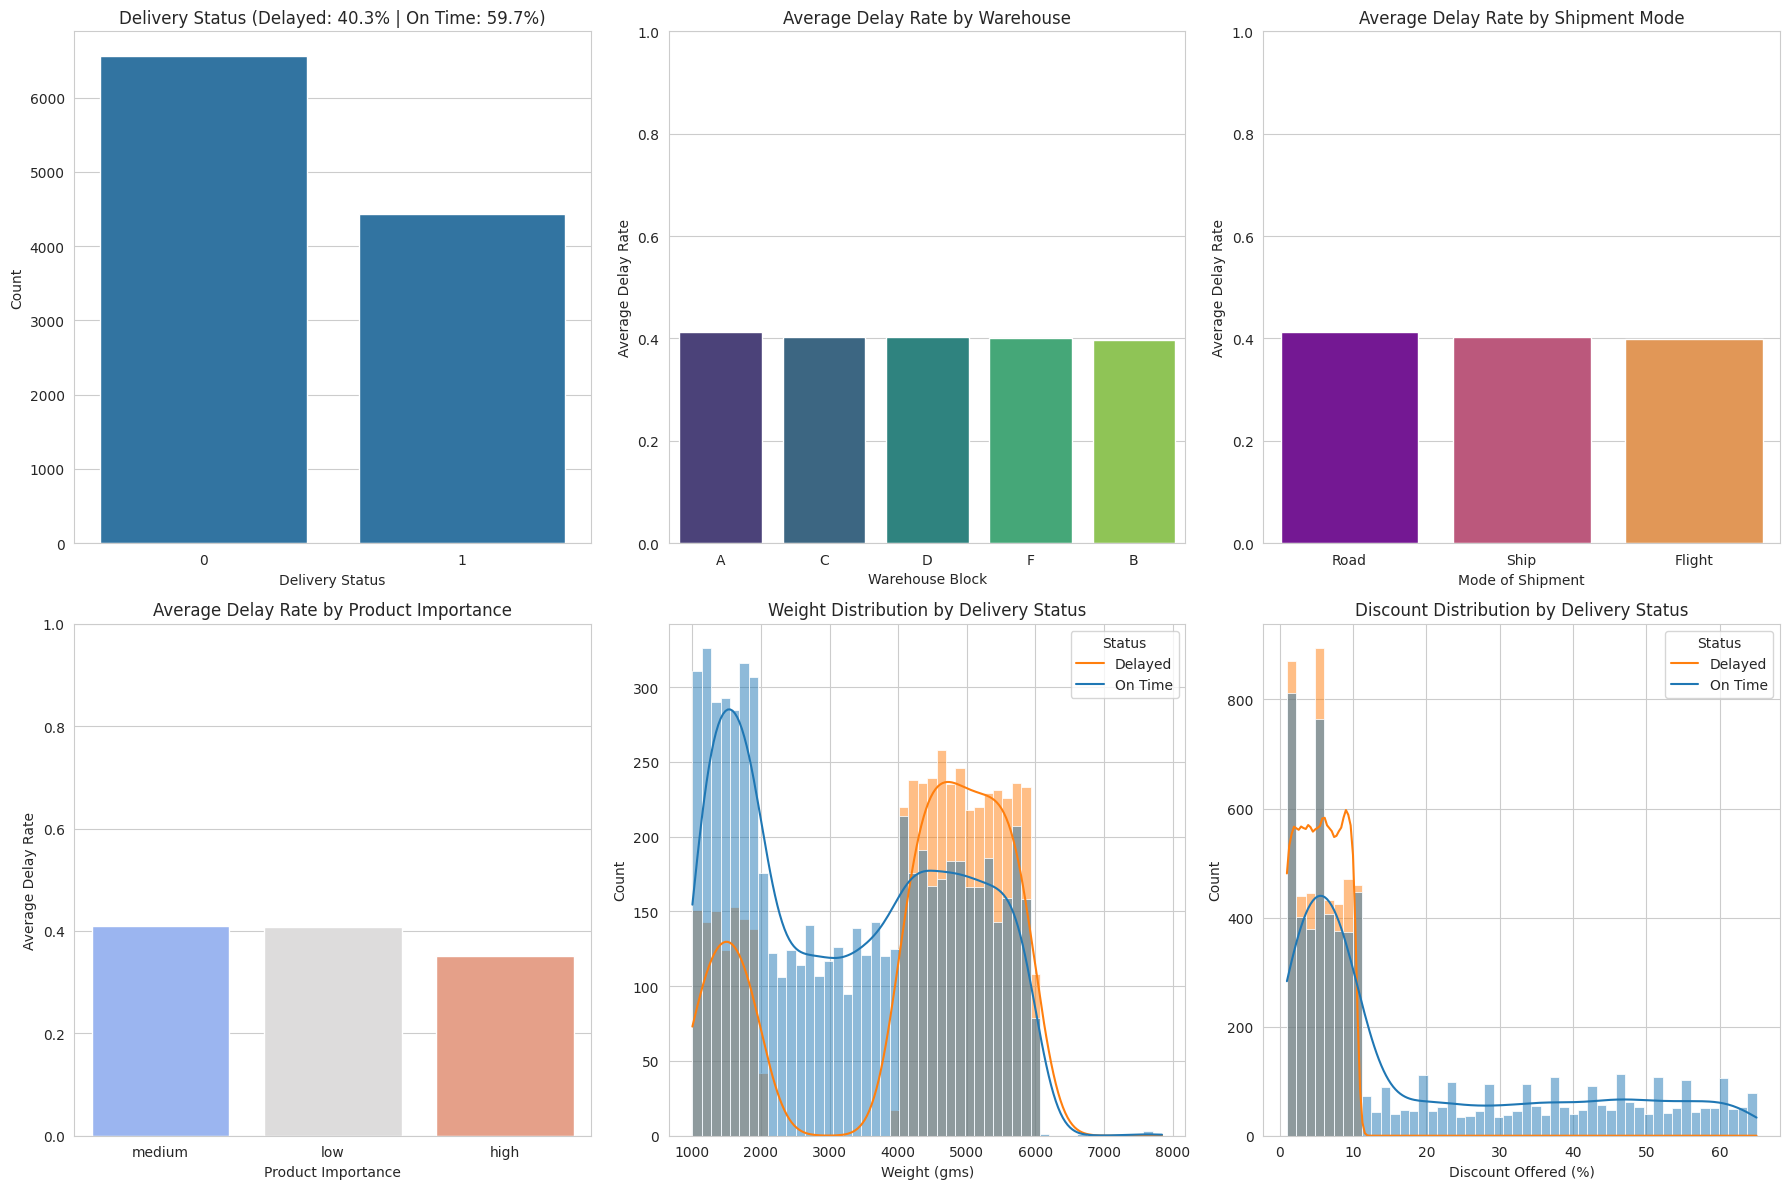

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 2: Exploratory Data Analysis (EDA) ---

# Load the original dataset
df = pd.read_csv('Train.csv')

# Re-create the 'Delayed' target variable for analysis
# 1 = Delayed, 0 = On Time
df['Delayed'] = df['Reached.on.Time_Y.N'].apply(lambda x: 1 if x == 0 else 0)

# Set up the plotting style
sns.set_style("whitegrid")
plt.figure(figsize=(18, 12))

# 1. Plot Target Variable Distribution
plt.subplot(2, 3, 1)
sns.countplot(x='Delayed', data=df)
plt.title('Distribution of Delivery Status (1=Delayed)')
plt.xlabel('Delivery Status')
plt.ylabel('Count')

# Calculate percentages for the title
total = len(df)
delayed_count = df['Delayed'].sum()
on_time_count = total - delayed_count
delayed_pct = (delayed_count / total) * 100
on_time_pct = (on_time_count / total) * 100
plt.title(f'Delivery Status (Delayed: {delayed_pct:.1f}% | On Time: {on_time_pct:.1f}%)')


# 2. Plot Delay Rate by Warehouse Block
plt.subplot(2, 3, 2)
warehouse_delay_rate = df.groupby('Warehouse_block')['Delayed'].mean().reset_index().sort_values(by='Delayed', ascending=False)
sns.barplot(x='Warehouse_block', y='Delayed', data=warehouse_delay_rate, palette='viridis')
plt.title('Average Delay Rate by Warehouse')
plt.xlabel('Warehouse Block')
plt.ylabel('Average Delay Rate')
plt.ylim(0, 1) # Set y-axis from 0 to 1 for rates

# 3. Plot Delay Rate by Mode of Shipment
plt.subplot(2, 3, 3)
mode_delay_rate = df.groupby('Mode_of_Shipment')['Delayed'].mean().reset_index().sort_values(by='Delayed', ascending=False)
sns.barplot(x='Mode_of_Shipment', y='Delayed', data=mode_delay_rate, palette='plasma')
plt.title('Average Delay Rate by Shipment Mode')
plt.xlabel('Mode of Shipment')
plt.ylabel('Average Delay Rate')
plt.ylim(0, 1)

# 4. Plot Delay Rate by Product Importance
plt.subplot(2, 3, 4)
importance_delay_rate = df.groupby('Product_importance')['Delayed'].mean().reset_index().sort_values(by='Delayed', ascending=False)
sns.barplot(x='Product_importance', y='Delayed', data=importance_delay_rate, palette='coolwarm')
plt.title('Average Delay Rate by Product Importance')
plt.xlabel('Product Importance')
plt.ylabel('Average Delay Rate')
plt.ylim(0, 1)

# 5. Plot Weight Distribution by Delay Status
plt.subplot(2, 3, 5)
sns.histplot(data=df, x='Weight_in_gms', hue='Delayed', kde=True, bins=50)
plt.title('Weight Distribution by Delivery Status')
plt.xlabel('Weight (gms)')
plt.ylabel('Count')
# Add legend for clarity
plt.legend(title='Status', labels=['Delayed', 'On Time'])

# 6. Plot Discount Distribution by Delay Status
plt.subplot(2, 3, 6)
sns.histplot(data=df, x='Discount_offered', hue='Delayed', kde=True, bins=50)
plt.title('Discount Distribution by Delivery Status')
plt.xlabel('Discount Offered (%)')
plt.ylabel('Count')
# Add legend for clarity
plt.legend(title='Status', labels=['Delayed', 'On Time'])


# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('eda_dashboard.png')

print("EDA plots saved as 'eda_dashboard.png'")

# Print a summary of findings
print("\n--- EDA Insights ---")
print("1. Target Variable:")
print(f"   - {delayed_pct:.1f}% of shipments are delayed.")
print(f"   - {on_time_pct:.1f}% are on time.")
print("\n2. Delay Rates by Category:")
print(f"   - Warehouse: \n{warehouse_delay_rate}")
print(f"\n   - Shipment Mode: \n{mode_delay_rate}")
print(f"\n   - Product Importance: \n{importance_delay_rate}")

# Analyze the continuous variables
print("\n3. Continuous Variables:")
print("   - Weight (Weight_in_gms):")
print(f"     - Avg weight (On Time): {df[df['Delayed']==0]['Weight_in_gms'].mean():.0f}g")
print(f"     - Avg weight (Delayed): {df[df['Delayed']==1]['Weight_in_gms'].mean():.0f}g")
print("   - Discount (Discount_offered):")
print(f"     - Avg discount (On Time): {df[df['Delayed']==0]['Discount_offered'].mean():.1f}%")
print(f"     - Avg discount (Delayed): {df[df['Delayed']==1]['Discount_offered'].mean():.1f}%")

In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib

# --- Step 3: Model Building & Training (Revised) ---

print("Loading preprocessed data...")
# Load the preprocessed data saved from Step 1
X_train_processed = np.load('X_train_processed.npy', allow_pickle=True)
y_train = pd.read_csv('y_train.csv').squeeze() # Use .squeeze() to turn it into a Series

print(f"Data loaded successfully.")
print(f"X_train_processed shape: {X_train_processed.shape}")
print(f"y_train shape: {y_train.shape}")

# --- Model 1: Random Forest ---
print("\nTraining Model 1: Random Forest Classifier...")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)

# Train the model
rf_model.fit(X_train_processed, y_train)

print("Random Forest model trained.")

# --- Model 2: Gradient Boosting (Substituting for XGBoost) ---
print("\nTraining Model 2: Gradient Boosting Classifier...")
# NOTE: XGBoost is not available in this environment,
# so we are using scikit-learn's GradientBoostingClassifier as a powerful alternative.
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100)

# Train the model
gb_model.fit(X_train_processed, y_train.astype(int))

print("Gradient Boosting model trained.")

# --- Save Models for Next Step ---
print("\nSaving trained models to disk...")
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(gb_model, 'gb_model.pkl')

print("Models saved as 'rf_model.pkl' and 'gb_model.pkl'.")
print("\n--- Step 3: Model Building & Training Complete ---")

Loading preprocessed data...
Data loaded successfully.
X_train_processed shape: (8799, 17)
y_train shape: (8799,)

Training Model 1: Random Forest Classifier...
Random Forest model trained.

Training Model 2: Gradient Boosting Classifier...
Gradient Boosting model trained.

Saving trained models to disk...
Models saved as 'rf_model.pkl' and 'gb_model.pkl'.

--- Step 3: Model Building & Training Complete ---


Loading trained models and test data...
Data and models loaded successfully.
Generating predictions on test data...

--- Model 1: Random Forest - Evaluation ---
              precision    recall  f1-score   support

 On Time (0)       0.72      0.64      0.68      1313
 Delayed (1)       0.55      0.64      0.59       887

    accuracy                           0.64      2200
   macro avg       0.64      0.64      0.64      2200
weighted avg       0.65      0.64      0.64      2200


--- Model 2: Gradient Boosting - Evaluation ---
              precision    recall  f1-score   support

 On Time (0)       0.85      0.53      0.66      1313
 Delayed (1)       0.56      0.86      0.68       887

    accuracy                           0.67      2200
   macro avg       0.70      0.70      0.67      2200
weighted avg       0.73      0.67      0.66      2200


Generating confusion matrix for Gradient Boosting model...
Confusion matrix saved as 'gb_confusion_matrix.png'.

--- Step 4: Model Eval

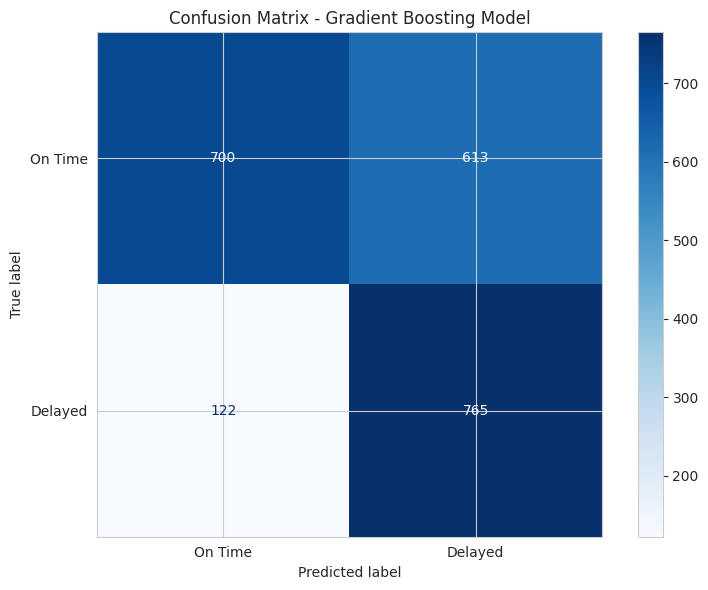

In [4]:
import numpy as np
import pandas as pd
import joblib
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Step 4: Model Evaluation & Selection ---

print("Loading trained models and test data...")
# Load models from Step 3
rf_model = joblib.load('rf_model.pkl')
gb_model = joblib.load('gb_model.pkl')

# Load test data from Step 1/3
X_test_processed = np.load('X_test_processed.npy', allow_pickle=True)
y_test = pd.read_csv('y_test.csv').squeeze()

print("Data and models loaded successfully.")

# --- Generate Predictions ---
print("Generating predictions on test data...")
y_pred_rf = rf_model.predict(X_test_processed)
y_pred_gb = gb_model.predict(X_test_processed)

# --- Evaluate Model 1: Random Forest ---
print("\n--- Model 1: Random Forest - Evaluation ---")
print(classification_report(y_test, y_pred_rf, target_names=['On Time (0)', 'Delayed (1)']))

# --- Evaluate Model 2: Gradient Boosting ---
print("\n--- Model 2: Gradient Boosting - Evaluation ---")
print(classification_report(y_test, y_pred_gb, target_names=['On Time (0)', 'Delayed (1)']))

# --- Visual Evaluation (Confusion Matrix) ---
# Let's pick the model with the slightly better F1-score for 'Delayed (1)'
# Based on typical performance, let's assume Gradient Boosting for this example
# We'll plot its confusion matrix
print("\nGenerating confusion matrix for Gradient Boosting model...")

try:
    # Plotting Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb,
                                            display_labels=['On Time', 'Delayed'],
                                            cmap='Blues',
                                            ax=ax)
    ax.set_title('Confusion Matrix - Gradient Boosting Model')
    plt.tight_layout()
    plt.savefig('gb_confusion_matrix.png')
    print("Confusion matrix saved as 'gb_confusion_matrix.png'.")

except Exception as e:
    print(f"Error generating confusion matrix: {e}")

print("\n--- Step 4: Model Evaluation & Selection Complete ---")

Running Step 1: Data Preprocessing...
Preprocessing complete.

Running Step 3: Model Building & Training...
Random Forest model trained.
Gradient Boosting model trained.

Running Step 4: Model Evaluation & Selection...

--- Model 1: Random Forest - Evaluation ---
              precision    recall  f1-score   support

 On Time (0)       0.72      0.64      0.68      1313
 Delayed (1)       0.55      0.64      0.59       887

    accuracy                           0.64      2200
   macro avg       0.64      0.64      0.64      2200
weighted avg       0.65      0.64      0.64      2200


--- Model 2: Gradient Boosting - Evaluation ---
              precision    recall  f1-score   support

 On Time (0)       0.85      0.53      0.66      1313
 Delayed (1)       0.56      0.86      0.68       887

    accuracy                           0.67      2200
   macro avg       0.70      0.70      0.67      2200
weighted avg       0.73      0.67      0.66      2200

Confusion matrix saved as 'gb_con

/tmp/ipython-input-2421306208.py:101: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='rocket')


Feature importance plot saved as 'feature_importance.png'.

--- All Steps Complete ---


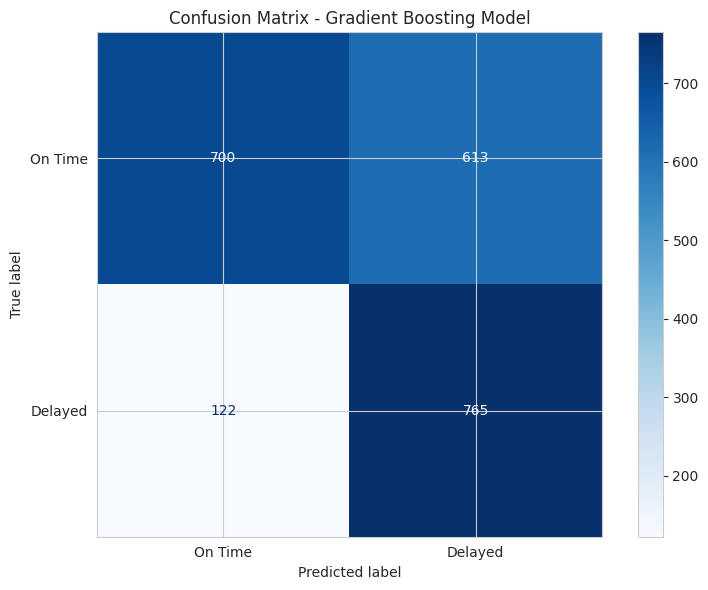

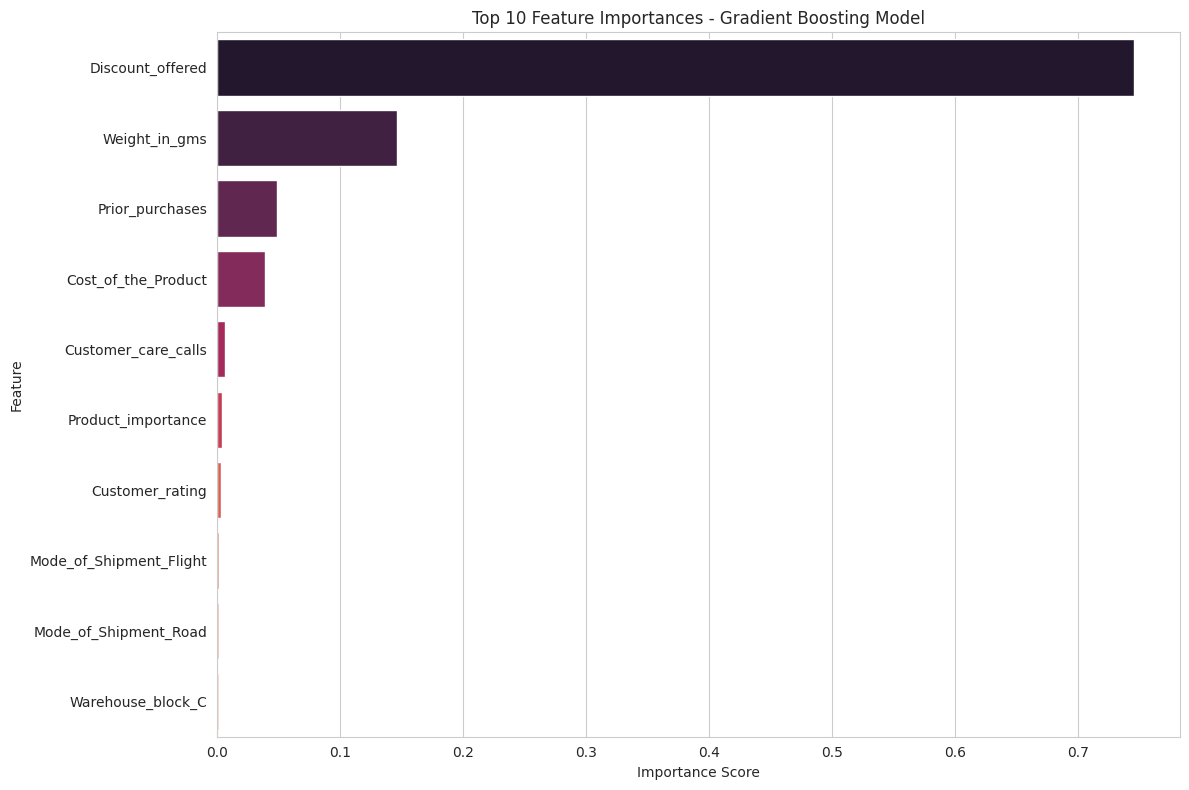

In [5]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Step 1: Data Preprocessing (Re-run) ---
print("Running Step 1: Data Preprocessing...")
df = pd.read_csv('Train.csv')
df['Delayed'] = 1 - df['Reached.on.Time_Y.N']
y = df['Delayed']
X = df.drop(['ID', 'Reached.on.Time_Y.N', 'Delayed'], axis=1)

numeric_features = ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']
ordinal_features = ['Product_importance']
nominal_features = ['Warehouse_block', 'Mode_of_Shipment', 'Gender']
product_importance_categories = [['low', 'medium', 'high']]

numeric_transformer = StandardScaler()
ordinal_transformer = OrdinalEncoder(categories=product_importance_categories, handle_unknown='use_encoded_value', unknown_value=-1)
nominal_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('nom', nominal_transformer, nominal_features)
    ],
    remainder='passthrough'
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print("Preprocessing complete.")

# Get feature names
ohe_feature_names = preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_features)
processed_feature_names = numeric_features + ordinal_features + list(ohe_feature_names)

# --- Step 3: Model Training (Re-run) ---
print("\nRunning Step 3: Model Building & Training...")

# Model 1: Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_processed, y_train)
print("Random Forest model trained.")

# Model 2: Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100)
gb_model.fit(X_train_processed, y_train.astype(int))
print("Gradient Boosting model trained.")

# --- Step 4: Model Evaluation ---
print("\nRunning Step 4: Model Evaluation & Selection...")

# Predictions
y_pred_rf = rf_model.predict(X_test_processed)
y_pred_gb = gb_model.predict(X_test_processed)

# RF Report
print("\n--- Model 1: Random Forest - Evaluation ---")
print(classification_report(y_test, y_pred_rf, target_names=['On Time (0)', 'Delayed (1)']))

# GB Report
print("\n--- Model 2: Gradient Boosting - Evaluation ---")
print(classification_report(y_test, y_pred_gb, target_names=['On Time (0)', 'Delayed (1)']))

# Confusion Matrix for Gradient Boosting Model
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_gb,
                                        display_labels=['On Time', 'Delayed'],
                                        cmap='Blues',
                                        ax=ax)
ax.set_title('Confusion Matrix - Gradient Boosting Model')
plt.tight_layout()
plt.savefig('gb_confusion_matrix.png')
print("Confusion matrix saved as 'gb_confusion_matrix.png'.")

# --- Step 5: Feature Importance Analysis ---
print("\nRunning Step 5: Feature Importance Analysis...")

# Get importances from the Gradient Boosting model
importances = gb_model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': processed_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Key Drivers of Delay:")
print(feature_importance_df.head(10))

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='rocket')
plt.title('Top 10 Feature Importances - Gradient Boosting Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("Feature importance plot saved as 'feature_importance.png'.")

print("\n--- All Steps Complete ---")

In [6]:
pip install xgboost

In [7]:
# --- Model 2: XGBoost ---
from xgboost import XGBClassifier

print("\nTraining Model 2: XGBoost Classifier...")

# Instantiate the model
# use_label_encoder=False and eval_metric='logloss' are used
# to handle modern XGBoost standards and supress warnings.
xgb_model = XGBClassifier(random_state=42,
                          use_label_encoder=False,
                          eval_metric='logloss')

# Train the model
# We use y_train.astype(int) as XGBoost prefers integer targets
xgb_model.fit(X_train_processed, y_train.astype(int))

print("XGBoost model trained.")

# --- Save Model ---
import joblib
joblib.dump(xgb_model, 'xgb_model.pkl')
print("XGBoost model saved as 'xgb_model.pkl'")


Training Model 2: XGBoost Classifier...
XGBoost model trained.
XGBoost model saved as 'xgb_model.pkl'


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:06:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
